In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from progressbar import ProgressBar
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import joblib
import itertools


In [22]:
df_orders_jan = pd.read_csv('../data/raw/orders_before_jan.csv',sep='|')
df_orders_jan

,date,userID,itemID,order
0,2020-06-01,38769,3477,1
1,2020-06-01,42535,30474,1
2,2020-06-01,42535,15833,1
3,2020-06-01,42535,20131,1
4,2020-06-01,42535,4325,1
...,...,...,...,...
905876,2020-12-31,38399,32075,1
905877,2020-12-31,38399,23050,1
905878,2020-12-31,21613,25422,1
905879,2020-12-31,27030,52,1


In [23]:
# Mini dataset
#df_orders_jan = df_orders_jan[(df_orders_jan['userID'].isin( range(0,150)))]
#df_orders_jan

In [4]:
df_gold_jan = pd.read_csv('../data/gold_jan.csv',sep='|')
df_gold_jan

,userID,itemID,prediction
0,0,20664,0
1,0,28231,4
2,13,2690,0
3,15,1299,2
4,15,20968,4
...,...,...,...
9935,46118,20106,0
9936,46124,19677,4
9937,46125,12878,0
9938,46127,7963,0


## EDA

In [5]:
pd.DataFrame(df_orders_jan['userID'].astype(str)+'_'+df_orders_jan['itemID'].astype(str)).nunique()


0    773540
dtype: int64

(1.0, 10.0)

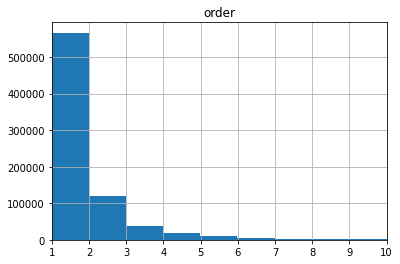

In [24]:
df_orders_jan.groupby(['userID', 'itemID']).sum().hist(bins=490) #df_orders_jan.groupby(['userID', 'itemID']).sum().max()
plt.xlim(1,10)

(1.0, 70.0)

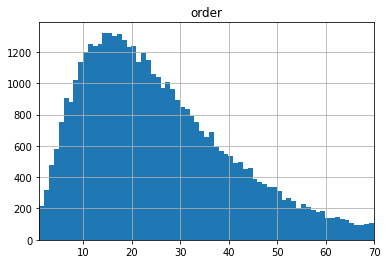

In [25]:
df_orders_jan.groupby(['userID']).sum()[['order']].hist(bins=586)
plt.xlim(1,70)

(1.0, 70.0)

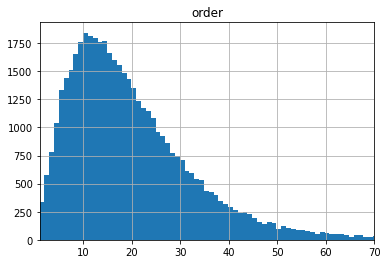

In [26]:
df_orders_jan.groupby(['userID']).count()[['order']].hist(bins=239)
plt.xlim(1,70)

(1.0, 30.0)

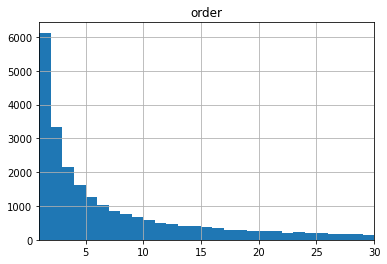

In [27]:
df_orders_jan.groupby(['itemID']).sum()[['order']].hist(bins=24722)
plt.xlim(1,30)

## Transformations

### Add dates features

In [5]:
def date_features(df):
    # Date Features
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df.date.dt.month
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear
    #df['day'] = df.date.dt.day
    #df['year'] = df.date.dt.year
    
    # Generate correponding week starting from the last day of the month
    dayofyear = df.date.dt.dayofyear
    n, p = max(dayofyear), min(dayofyear)
    week = math.ceil((n-p+1)/7)
    df['week'] = 0
    while n >= p:
        m = n-7
        df['week'] = np.where((dayofyear>m)&(dayofyear<=n), week, df['week'])
        week -= 1
        n = m
    
    # Number of days since last order of a product per item
    df.sort_values(['userID', 'itemID', 'dayofyear'], inplace=True)
    df['n_days'] = df['dayofyear'] - df.groupby(['userID', 'itemID'])['dayofyear'].shift(1)
    df['n_days'] = df['n_days'].fillna(0)
    
    # Drop date
    df.drop('date', axis=1, inplace=True)

    return df

In [6]:
df_orders_jan = date_features(df_orders_jan)
df_orders_jan

,userID,itemID,order,month,dayofweek,dayofyear,week,n_days
390966,0,1505,1,9,1,245,14,0.0
819667,0,6446,1,12,4,346,29,0.0
709719,0,9325,1,11,4,325,26,0.0
268197,0,12468,1,8,0,216,10,0.0
334333,0,12505,1,8,1,231,12,0.0
...,...,...,...,...,...,...,...,...
453489,46137,2667,1,9,3,261,16,0.0
287155,46137,20209,1,8,5,221,11,0.0
287156,46137,28343,1,8,5,221,11,0.0
287097,46137,28900,2,8,5,221,11,0.0


In [7]:
#df_orders_jan[(df_orders_jan['ndays']!=0)] # maybe use this cut to train after filling

### Transform  dataset into a week based

In [8]:
def week_features(df):
    # Number of days since last order of a user per item
    df.sort_values(['userID', 'itemID', 'week'], inplace=True)
    df['n_weeks'] = df['week'] - df.groupby(['userID', 'itemID'])['week'].shift(1)
    df['n_weeks'] = df['n_weeks'].fillna(0)
    
    #Order of last time a user order that item
    df['order_last'] = df.groupby(['userID', 'itemID'])['order'].shift(1)
    df['order_last'] = df['order_last'].fillna(0)
    
    #Order of last time a user order that item
    #df['order_diff_last'] = df.groupby(['userID', 'itemID'])['order'].diff(1)
    
    return df

In [9]:
df_orders_jan_w = df_orders_jan.groupby(['userID', 'itemID', 'week'], 
                                        as_index=False).agg(order=('order','sum'),
                                                            month_avg= ('month','mean'), 
                                                            dayofweek_avg=('dayofweek','mean'),
                                                            n_days_avg =('n_days','mean'),
                                                           )

df_orders_jan_w = week_features(df_orders_jan_w)
df_orders_jan_w


,userID,itemID,week,order,month_avg,dayofweek_avg,n_days_avg,n_weeks,order_last
0,0,1505,14,1,9.0,1.0,0.0,0.0,0.0
1,0,6446,29,1,12.0,4.0,0.0,0.0,0.0
2,0,9325,26,1,11.0,4.0,0.0,0.0,0.0
3,0,12468,10,1,8.0,0.0,0.0,0.0,0.0
4,0,12505,12,1,8.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
904067,46137,2667,16,1,9.0,3.0,0.0,0.0,0.0
904068,46137,20209,11,1,8.0,5.0,0.0,0.0,0.0
904069,46137,28343,11,1,8.0,5.0,0.0,0.0,0.0
904070,46137,28900,11,2,8.0,5.0,0.0,0.0,0.0


In [10]:
df_orders_jan_w[(df_orders_jan_w['order_last']!=0)]

,userID,itemID,week,order,month_avg,dayofweek_avg,n_days_avg,n_weeks,order_last
7,0,20664,20,1,10.0,4.0,126.0,18.0,1.0
8,0,20664,29,1,12.0,4.0,63.0,9.0,1.0
11,0,28231,29,1,12.0,4.0,21.0,3.0,1.0
22,1,23055,27,2,11.0,6.0,20.0,3.0,1.0
36,2,23476,17,1,9.0,2.0,86.0,12.0,1.0
...,...,...,...,...,...,...,...,...,...
903980,46133,5468,25,1,11.0,5.0,47.0,7.0,1.0
904016,46134,21901,16,2,9.0,1.0,51.0,7.0,1.0
904033,46136,1782,31,5,12.0,0.0,184.0,26.0,4.0
904062,46136,29657,31,5,12.0,0.0,184.0,26.0,5.0


### Fill weeks with no purchases

In [20]:
df_ui_unique_jan = df_orders_jan_w.groupby(['userID', 'itemID']).count().reset_index()[['userID', 'itemID']]
end = df_orders_jan_w['week'].max()

ls_user = []
ls_item = []
ls_week = []

pbar = ProgressBar()
for x in pbar(range(0, len(df_ui_unique_jan))):
    u, i = df_ui_unique_jan.loc[x]
    
    start = df_orders_jan_w[(df_orders_jan_w['userID']==u)&(df_orders_jan_w['itemID']==i)]['week'].min()
    
    ws = list(range(start, end+1))
    len_ws = len(ws)
    ls_week.append(ws)
    ls_user.append([u]*len_ws)
    ls_item.append([i]*len_ws)

df_user_item_jan_w = pd.DataFrame({'week':list(itertools.chain.from_iterable(ls_week)), 
                                   'userID':list(itertools.chain.from_iterable(ls_user)), 
                                   'itemID':list(itertools.chain.from_iterable(ls_item))})
df_user_item_jan_w.reset_index(inplace=True, drop=True)
df_user_item_jan_w.to_csv('../data/interim/orders_str_before_jan.csv',sep='|', index=False)

df_user_item_jan_w

,week,userID,itemID
0,14,0,1505
1,15,0,1505
2,16,0,1505
3,17,0,1505
4,18,0,1505
...,...,...,...
12725887,27,46137,32292
12725888,28,46137,32292
12725889,29,46137,32292
12725890,30,46137,32292


In [21]:
df_orders_jan_c = df_user_item_jan_w.merge(df_orders_jan_w, 
                                   how='left', 
                                   left_on=['userID', 'itemID', 'week'], 
                                   right_on=['userID', 'itemID', 'week'])

#Filling Nans
df_orders_jan_c['order'] = df_orders_jan_c['order'].fillna(0)
#df_orders_jan_c['order_last'] = df_orders_jan_c.groupby(['userID', 'itemID'])['order_last'].apply(lambda x: x.bfill())

df_orders_jan_c.to_csv('../data/interim/orders_before_jan_complete.csv',sep='|', index=False)
df_orders_jan_c


,week,userID,itemID,order,month_avg,dayofweek_avg,n_days_avg,n_weeks,order_last
0,14,0,1505,1.0,9.0,1.0,0.0,0.0,0.0
1,15,0,1505,0.0,NaN,NaN,NaN,NaN,NaN
2,16,0,1505,0.0,NaN,NaN,NaN,NaN,NaN
3,17,0,1505,0.0,NaN,NaN,NaN,NaN,NaN
4,18,0,1505,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
12725887,27,46137,32292,0.0,NaN,NaN,NaN,NaN,NaN
12725888,28,46137,32292,0.0,NaN,NaN,NaN,NaN,NaN
12725889,29,46137,32292,0.0,NaN,NaN,NaN,NaN,NaN
12725890,30,46137,32292,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
#df_orders_jan_c[(df_orders_jan_c['userID']==22696)&(df_orders_jan_c['itemID']==840)]

## Train / Validation Split

In [ ]:
#df_orders_jan_c = pd.read_csv('../data/interim/orders_before_jan_complete.csv',sep='|')

In [28]:
# Select features
features = ['week', 'userID', 'itemID', 'order']
df_complete = df_orders_jan_c[features].copy()

In [29]:
# Split
split_point = df_complete['week'].max()-4
df_train = df_complete[df_complete['week'] < split_point].copy()
df_val = df_complete[df_complete['week'] >= split_point].copy()
df_train.head()


,week,userID,itemID,order
0,14,0,1505,1.0
1,15,0,1505,0.0
2,16,0,1505,0.0
3,17,0,1505,0.0
4,18,0,1505,0.0


In [30]:
# Create labels for 4-steps train 
df_train['w1'] = df_train.groupby(['userID', 'itemID'])['order'].shift(-1)
df_train['w2'] = df_train.groupby(['userID', 'itemID'])['order'].shift(-2)
df_train['w3'] = df_train.groupby(['userID', 'itemID'])['order'].shift(-3)
df_train['w4'] = df_train.groupby(['userID', 'itemID'])['order'].shift(-4)
df_train = df_train.dropna(subset=['w1','w2','w3','w4'])
df_train.drop('order', axis=1, inplace=True)

df_train

,week,userID,itemID,w1,w2,w3,w4
0,14,0,1505,0.0,0.0,0.0,0.0
1,15,0,1505,0.0,0.0,0.0,0.0
2,16,0,1505,0.0,0.0,0.0,0.0
3,17,0,1505,0.0,0.0,0.0,0.0
4,18,0,1505,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
12725878,18,46137,32292,0.0,0.0,0.0,0.0
12725879,19,46137,32292,0.0,0.0,0.0,0.0
12725880,20,46137,32292,0.0,0.0,0.0,0.0
12725881,21,46137,32292,0.0,0.0,0.0,0.0


In [31]:
# Create labels for 4-steps validation 
df_val['w1'] = df_val.groupby(['userID', 'itemID'])['order'].shift(-1)
df_val['w2'] = df_val.groupby(['userID', 'itemID'])['order'].shift(-2)
df_val['w3'] = df_val.groupby(['userID', 'itemID'])['order'].shift(-3)
df_val['w4'] = df_val.groupby(['userID', 'itemID'])['order'].shift(-4)
df_val = df_val.dropna(subset=['w1','w2','w3','w4'])
df_val.drop('order', axis=1, inplace=True)

df_val

,week,userID,itemID,w1,w2,w3,w4
13,27,0,1505,0.0,0.0,0.0,0.0
22,27,0,9325,0.0,0.0,0.0,0.0
44,27,0,12468,0.0,0.0,0.0,0.0
64,27,0,12505,0.0,0.0,0.0,0.0
86,27,0,15083,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
12725803,27,46137,2667,0.0,0.0,0.0,0.0
12725824,27,46137,20209,0.0,0.0,0.0,0.0
12725845,27,46137,28343,0.0,0.0,0.0,0.0
12725866,27,46137,28900,0.0,0.0,0.0,0.0


## Create Basic Time-Series Features

In [32]:
def lags(df, ls):
    for n in ls:
        df['lag_order_%s'%n] = df.groupby(['userID', 'itemID'])['order'].shift(n)
    return df
        
def diff(df, ls):
    for n in ls:
        df['dif_order_%s'%n] = df.groupby(['userID', 'itemID'])['order'].diff(n)
    return df

def roll_mean(df, ls):
    for n in ls:
        df['mean_order_%s'%n] = df.groupby(['userID', 'itemID'])['order'].rolling(n).mean().reset_index(level=[0,1], drop=True)
    return df

def roll_std(df, ls):
    for n in ls:
        df['std_order_%s'%n] = df.groupby(['userID', 'itemID'])['order'].rolling(n).std().reset_index(level=[0,1], drop=True)
    return df

    


In [33]:
# Could be better for val features
df_complete = lags(df_complete, range(1,9))
df_complete = diff(df_complete, range(1,5))
df_complete = roll_mean(df_complete, [4,8])
df_complete = roll_std(df_complete, [4,8])
df_complete.to_csv('../data/interim/orders_before_jan_features.csv',sep='|')


In [34]:
# Insert features to the train, validation and test dataframe
df_train = df_train.merge(df_complete, 
                          how='left', 
                          left_on=['userID', 'itemID', 'week'], 
                          right_on=['userID', 'itemID', 'week'])

df_val = df_val.merge(df_complete, 
                      how='left', 
                      left_on=['userID', 'itemID', 'week'], 
                      right_on=['userID', 'itemID', 'week'])

df_gold_jan['week'] = df_complete['week'].max()
df_test = df_gold_jan[['userID', 'itemID', 'week']].merge(df_complete, 
                                                          how='left', 
                                                          left_on=['userID', 'itemID', 'week'], 
                                                          right_on=['userID', 'itemID', 'week'])


## Train Models

In [36]:
y_features = ['w1', 'w2','w3','w4']
X_features = ['order','lag_order_2', 'lag_order_3', 'lag_order_4', 'lag_order_5',
              'dif_order_1', 'dif_order_2', 'dif_order_3', 'dif_order_4',
              'mean_order_4', 'mean_order_8', 'std_order_4', 'std_order_8'
             ]
train = df_train[y_features+X_features] #.dropna().drop_duplicates()
val = df_val[y_features+X_features]

imputer = SimpleImputer(strategy='most_frequent')
X_train = imputer.fit_transform(train[X_features])
y_train = train[y_features]

X_val = imputer.fit_transform(val[X_features])
y_val = val[y_features]

### RFR

In [37]:
rfr = RandomForestRegressor(n_estimators=100, random_state=46, n_jobs=-1)
rfr.fit(X_train, y_train)
                
joblib.dump(rfr, '../models/pred_jan_rfr.sav')

['../models/pred_jan_rfr.sav']

### XGB

In [40]:
# XGB Model
matrix_train = xgb.DMatrix(X_train, label = y_train)
matrix_val = xgb.DMatrix(X_val, label = y_val)

# Run XGB 
xgreg = xgb.train(params={'objective':'reg:linear','eval_metric':'mae'},
                  dtrain = matrix_train, num_boost_round = 500,
                  early_stopping_rounds = 20, evals = [(matrix_val,'val')],)

[11:19:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	val-mae:0.36624
[1]	val-mae:0.26775
[2]	val-mae:0.19875
[3]	val-mae:0.15042
[4]	val-mae:0.11658
[5]	val-mae:0.09288
[6]	val-mae:0.07631
[7]	val-mae:0.06471
[8]	val-mae:0.05658
[9]	val-mae:0.05087
[10]	val-mae:0.04690
[11]	val-mae:0.04410
[12]	val-mae:0.04218
[13]	val-mae:0.04080
[14]	val-mae:0.03983
[15]	val-mae:0.03917
[16]	val-mae:0.03871
[17]	val-mae:0.03837
[18]	val-mae:0.03815
[19]	val-mae:0.03800
[20]	val-mae:0.03788
[21]	val-mae:0.03781
[22]	val-mae:0.03776
[23]	val-mae:0.03770
[24]	val-mae:0.03766
[25]	val-mae:0.03765
[26]	val-mae:0.03766
[27]	val-mae:0.03765
[28]	val-mae:0.03764
[29]	val-mae:0.03763
[30]	val-mae:0.03764
[31]	val-mae:0.03764
[32]	val-mae:0.03766
[33]	val-mae:0.03766
[34]	val-mae:0.03767
[35]	val-mae:0.03766
[36]	val-mae:0.03766
[37]	val-mae:0.03766
[38]

## Models Prediction

In [45]:
X_test = imputer.fit_transform(df_test[X_features])
rfr_p = np.around(rfr.predict(X_test))

df_test_pred = pd.DataFrame(rfr_p, columns = ['w1','w2','w3','w4'])
conditions = [
    (df_test_pred['w1'] >0),
    (df_test_pred['w2'] >0),
    (df_test_pred['w3'] >0),
    (df_test_pred['w4'] >0)
    ]
choices = [1,2,3,4]

df_pred_jan_rfr = df_gold_jan[['userID', 'itemID']].copy()
df_pred_jan_rfr['prediction'] = np.select(conditions, choices, default=0)
df_pred_jan_rfr.to_csv('../data/predictions/pred_jan_rfr.csv',sep='|', index=False)

In [46]:
X_test = imputer.fit_transform(df_test[X_features])
matrix_test = xgb.DMatrix(X_test)
xgreg_p = np.around(xgreg.predict(matrix_test, ntree_limit=xgreg.best_ntree_limit))

df_test_pred = pd.DataFrame(xgreg_p, columns = ['w1','w2','w3','w4'])
conditions = [
    (df_test_pred['w1'] >0),
    (df_test_pred['w2'] >0),
    (df_test_pred['w3'] >0),
    (df_test_pred['w4'] >0)
    ]
choices = [1,2,3,4]

df_pred_jan_xgreg = df_gold_jan[['userID', 'itemID']].copy()
df_pred_jan_xgreg['prediction'] = np.select(conditions, choices, default=0)
df_pred_jan_xgreg.to_csv('../data/predictions/pred_jan_xgreg.csv',sep='|', index=False)

/Users/victoriazevallos/anaconda3/envs/snake8/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
